In [1]:
import os
import os.path
import requests
import zipfile
import logging
import torch

import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from typing import Optional, List, Dict, Tuple
from collections import Counter
from rectools import Columns
from rectools.dataset import Dataset as RTDataset
from rectools.metrics import calc_metrics, NDCG, MAP, MeanInvUserFreq
from rectools.models import model_from_config

import warnings
warnings.filterwarnings("ignore")

/home/koshkidadanet/My Files/reco-service-itmo/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.basicConfig(
    filename='training.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

In [3]:
K_RECOS = 10
RANDOM_STATE = 49
NUM_THREADS = 0
map10 = MAP(k=K_RECOS)

# –ß—Ç–µ–Ω–∏–µ –¥–∞–Ω–Ω—ã—Ö

In [4]:
# data_path = os.environ.get("DATA_PATH")

# def download_and_extract():
#     url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'
#     filename = 'kion_train.zip'

#     response = requests.get(url, stream=True)
#     with open(filename, 'wb') as f:
#         total = int(response.headers.get('content-length', 0))
#         progress = tqdm(response.iter_content(1024 * 1024),
#                         f"Downloading {filename}",
#                         total=total // (1024 * 1024), unit='MB')
#         for chunk in progress:
#             f.write(chunk)

#     with zipfile.ZipFile(filename, 'r') as zip_ref:
#         zip_ref.extractall("../../data")
#     os.remove(filename)

# download_and_extract()

In [5]:
data_path = os.environ.get("DATA_PATH")

if data_path is None:
    data_path = "../../data/data_original"  # –≤–∞—à –ø—É—Ç—å –∫ –¥–∞–Ω–Ω—ã–º –¥–æ –ø–∞–ø–∫–∏ data_original –≤–∫–ª—é—á–∏—Ç–µ–ª—å–Ω–æ

interactions_df = (
    pd.read_csv(os.path.join(data_path, "interactions.csv"), parse_dates=["last_watch_dt"])
    .rename(columns={'last_watch_dt': Columns.Datetime, 'watched_pct': Columns.Weight})
)
users_df = pd.read_csv(os.path.join(data_path, "users.csv"))
items_df = pd.read_csv(os.path.join(data_path, "items.csv"))

## –¢—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–∞—è –∏ —Ç–µ—Å—Ç–æ–≤–∞—è –≤—ã–±–æ—Ä–∫–∏

In [6]:
N_DAYS = 7

max_date = interactions_df['datetime'].max()
train_interactions = interactions_df[(interactions_df['datetime'] <= max_date - pd.Timedelta(days=N_DAYS))]
test_interactions = interactions_df[(interactions_df['datetime'] > max_date - pd.Timedelta(days=N_DAYS))]

cold_users = set(test_interactions[Columns.User].unique()) - set(train_interactions[Columns.User])

test_interactions = test_interactions[~test_interactions[Columns.User].isin(cold_users)]
hot_users = test_interactions[Columns.User].unique()

rt_dataset = RTDataset.construct(test_interactions)

# –û–±—Ä–∞–±–æ—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö

## –§–∏–ª—å—Ç—Ä–∞—Ü–∏—è
- –ï—Å–ª–∏ –Ω–µ —Ñ–∏–ª—å—Ç—Ä–æ–≤–∞—Ç—å –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π –∏ —Ñ–∏–ª—å–º—ã –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π, —Ç–æ lightfm —Ä–∞–±–æ—Ç–∞–µ—Ç –Ω–∞–º–Ω–æ–≥–æ –ª—É—á—à–µ

In [7]:
print(f"N users before: {train_interactions.user_id.nunique()}")
print(f"N items before: {train_interactions.item_id.nunique()}\n")

train_interactions = train_interactions.dropna(subset='weight')

# —Å–æ–±–µ—Ä–µ–º –≤—Å–µ—Ö –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Å–º–æ—Ç—Ä–µ–ª–∏
# –±–æ–ª—å—à–µ 5 —Ñ–∏–ª—å–º–æ–≤ (–º–æ–∂–µ—Ç–µ –≤—ã–±—Ä–∞—Ç—å –¥—Ä—É–≥–æ–π –ø–æ—Ä–æ–≥)
valid_users = []

c = Counter(train_interactions.user_id)
for user_id, entries in c.most_common():
    if entries > 5:
        valid_users.append(user_id)

# –∏ —Å–æ–±–µ—Ä–µ–º –≤—Å–µ —Ñ–∏–ª—å–º—ã, –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Å–º–æ—Ç—Ä–µ–ª–∏ –±–æ–ª—å—à–µ 10 –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π
valid_items = []

c = Counter(train_interactions.item_id)
for item_id, entries in c.most_common():
    if entries > 10:
        valid_items.append(item_id)

# –æ—Ç–±—Ä–æ—Å–∏–º –Ω–µ–ø–æ–ø—É–ª—è—Ä–Ω—ã–µ —Ñ–∏–ª—å–º—ã –∏ –Ω–µ–∞–∫—Ç–∏–≤–Ω—ã—Ö —é–∑–µ—Ä–æ–≤
train_interactions = train_interactions[
    (train_interactions.user_id.isin(valid_users))
    & (train_interactions.item_id.isin(valid_items))
    | (train_interactions.user_id.isin(hot_users))
]

users_df = users_df[users_df.user_id.isin(train_interactions.user_id.unique())]
train_interactions = train_interactions[train_interactions.user_id.isin(users_df.user_id.unique())]
items_df = items_df[items_df.item_id.isin(train_interactions.item_id.unique())]

print(f"N users after: {train_interactions.user_id.nunique()}")
print(f"N items after: {train_interactions.item_id.nunique()}")

N users before: 906071
N items before: 15577

N users after: 231872
N items after: 12029


## –ö–æ–¥–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [8]:
# your code here
user_cat_feats = ["age", "income", "sex", "kids_flg"]
# –∏–∑ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ –æ—Å—Ç–∞–≤–∏–º —Ç–æ–ª—å–∫–æ item_id - —ç—Ç–æ—Ç –ø—Ä–∏–∑–Ω–∞–∫ –Ω–∞–º –ø–æ–Ω–∞–¥–æ–±–∏—Ç—Å—è –ø–æ–∑–∂–µ
# –¥–ª—è —Ç–æ–≥–æ, —á—Ç–æ–±—ã –º–∞–ø–ø–∏—Ç—å –∞–π—Ç–µ–º—ã –∏–∑ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ —Å —Ñ–∏–ª—å–º–∞–º–∏ —Å –∞–π—Ç–µ–º–∞–º–∏
# –∏–∑ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞ —Å –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏—è–º–∏
users_ohe_df = users_df.user_id
for feat in user_cat_feats:
    # –ø–æ–ª—É—á–∞–µ–º –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å one-hot encoding –¥–ª—è –∫–∞–∂–¥–æ–π –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω–æ–π —Ñ–∏—á–∏
    ohe_feat_df = pd.get_dummies(users_df[feat], prefix=feat)
    # –∫–æ–Ω–∫–∞—Ç–µ–Ω–∏—Ä—É–µ–º ohe-hot –¥–∞—Ç–∞—Ñ—Ä–µ–π–º —Å –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–æ–º,
    # –∫–æ—Ç–æ—Ä—ã–π –º—ã –ø–æ–ª—É—á–∏–ª–∏ –Ω–∞ –ø—Ä–µ–¥—ã–¥—É—â–µ–º —à–∞–≥–µ
    users_ohe_df = pd.concat([users_ohe_df, ohe_feat_df], axis=1)

users_ohe_df.head()

user_id  age_age_18_24  age_age_25_34  age_age_35_44  age_age_45_54  \
1   962099              1              0              0              0   
3   721985              0              0              0              1   
4   704055              0              0              1              0   
8   846063              0              0              1              0   
9   401219              0              0              1              0   

   age_age_55_64  age_age_65_inf  income_income_0_20  income_income_150_inf  \
1              0               0                   0                      0   
3              0               0                   0                      0   
4              0               0                   0                      0   
8              0               0                   0                      0   
9              0               0                   0                      0   

   income_income_20_40  income_income_40_60  income_income_60_90  \
1                    1                    0                    0   
3                    1                    0                    0   
4                    0                    0                    1   
8                    0                    1                    0   
9                    0                    1                    0   

   income_income_90_150  sex_–ñ  sex_–ú  kids_flg_0  kids_flg_1  
1                     0      0      1           1           0  
3                     0      1      0           1           0  
4                     0      1      0           1           0  
8                     0      1      0           0           1  
9                     0      1      0           1           0

In [9]:
item_cat_feats = [
    'content_type',
    'for_kids', 'age_rating',
    'studios', 'countries'
]
items_ohe_df = items_df.item_id

for feat in item_cat_feats:
    ohe_feat_df = pd.get_dummies(items_df[feat], prefix=feat)
    items_ohe_df = pd.concat([items_ohe_df, ohe_feat_df], axis=1)

genre_dummies = items_df['genres'].str.get_dummies(sep=',')
genre_dummies.columns = ['genre_' + col for col in genre_dummies.columns]

items_ohe_df = pd.concat(
    [items_ohe_df, genre_dummies], axis=1
)

items_ohe_df.head()

item_id  content_type_film  content_type_series  for_kids_0.0  \
0    10711                  1                    0             0   
2    10716                  1                    0             0   
3     7868                  1                    0             0   
4    16268                  1                    0             0   
6     1468                  1                    0             0   

   for_kids_1.0  age_rating_0.0  age_rating_6.0  age_rating_12.0  \
0             0               0               0                0   
2             0               0               0                0   
3             0               0               0                0   
4             0               0               0                1   
6             0               0               1                0   

   age_rating_16.0  age_rating_18.0  ...  genre_—Ñ–∞–Ω—Ç–∞—Å—Ç–∏–∫–∞  genre_—Ñ–∏–ª—å–º—ã  \
0                1                0  ...                 0             0   
2                1                0  ...                 0             0   
3                1                0  ...                 0             0   
4                0                0  ...                 0             0   
6                0                0  ...                 0             1   

   genre_—Ñ–∏–ª—å–º—ã hbo  genre_—Ñ–∏—Ç–Ω–µ—Å  genre_—Ñ—É—Ç–±–æ–ª  genre_—Ñ—ç–Ω—Ç–µ–∑–∏  \
0                 0             0             0              0   
2                 0             0             0              0   
3                 0             0             0              0   
4                 0             0             0              0   
6                 0             0             0              0   

   genre_—Ö–æ—á—É –≤—Å—ë –∑–Ω–∞—Ç—å  genre_—à–æ—É  genre_—ç–∫—Ä–∞–Ω–∏–∑–∞—Ü–∏–∏  genre_—é–º–æ—Ä  
0                     0          0                  0           0  
2                     0          0                  0           0  
3                     0          0                  0           0  
4                     0          0                  0           0  
6                     0          0                  0           0  

[5 rows x 836 columns]

## –í–µ—Å

In [10]:
n_bins = 20
train_interactions['weight'] = pd.cut(train_interactions['weight'], bins=n_bins+1, labels=False)

## –¢–µ—Å—Ç lightFM

In [69]:
user_features_frames = []
for feature in users_ohe_df.drop('user_id', axis=1).columns:
    feature_frame = users_ohe_df.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features_lfm = pd.concat(user_features_frames)
display(user_features_lfm.head())

item_features_frames = []
for feature in items_ohe_df.drop('item_id', axis=1).columns:
    feature_frame = items_ohe_df.reindex(columns=[Columns.Item, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    item_features_frames.append(feature_frame)
item_features_lfm = pd.concat(item_features_frames)
display(item_features_lfm.head())

id  value        feature
1  962099      1  age_age_18_24
3  721985      0  age_age_18_24
4  704055      0  age_age_18_24
8  846063      0  age_age_18_24
9  401219      0  age_age_18_24

id  value            feature
0  10711      1  content_type_film
2  10716      1  content_type_film
3   7868      1  content_type_film
4  16268      1  content_type_film
6   1468      1  content_type_film

In [70]:
dataset_with_features = RTDataset.construct(
    interactions_df=train_interactions,
    user_features_df=user_features_lfm,
    cat_user_features=users_ohe_df.drop('user_id', axis=1).columns.to_list(),
    item_features_df=item_features_lfm,
    cat_item_features=items_ohe_df.drop('item_id', axis=1).columns.to_list(),
)

config = {
    'cls': 'LightFMWrapperModel',
    'model': {
        'no_components': 4,
        'loss': 'warp',
        'random_state': 42
    }
}

model = model_from_config(config)
model.fit(dataset_with_features)

recos = model.recommend(
    users=hot_users,
    dataset=dataset_with_features,
    k=K_RECOS,
    filter_viewed=True,
)

print(map10.calc(recos, test_interactions))

0.05360831868598573


## –ú–∞–ø–ø–∏–Ω–≥ uid –∏ iid

In [11]:
train_interactions["uid"] = train_interactions["user_id"].astype("category")
train_interactions["uid"] = train_interactions["uid"].cat.codes

train_interactions["iid"] = train_interactions["item_id"].astype("category")
train_interactions["iid"] = train_interactions["iid"].cat.codes

print(sorted(train_interactions.iid.unique())[:5])
print(sorted(train_interactions.uid.unique())[:5])
train_interactions.head()

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


user_id  item_id   datetime  total_dur  weight     uid   iid
0   176549     9506 2021-05-11       4250      15   37320  6899
1   699317     1659 2021-05-29       8317      20  147692  1223
3   864613     7638 2021-07-05      14483      20  182889  5544
6  1016458      354 2021-08-14       1672       5  214580   262
7   884009      693 2021-08-04        703       2  186918   513

In [12]:
iid_to_item_id = train_interactions[["iid", "item_id"]].drop_duplicates().set_index("iid").to_dict()["item_id"]
item_id_to_iid = train_interactions[["iid", "item_id"]].drop_duplicates().set_index("item_id").to_dict()["iid"]

uid_to_user_id = train_interactions[["uid", "user_id"]].drop_duplicates().set_index("uid").to_dict()["user_id"]
user_id_to_uid = train_interactions[["uid", "user_id"]].drop_duplicates().set_index("user_id").to_dict()["uid"]

In [13]:
items_ohe_df["iid"] = items_ohe_df["item_id"].map(item_id_to_iid)
items_ohe_df = items_ohe_df.set_index("iid")

users_ohe_df["uid"] = users_ohe_df["user_id"].map(user_id_to_uid)
users_ohe_df = users_ohe_df.set_index("uid")

# –ú–∞—Ç—Ä–∏—Ü–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π
- –§–æ—Ä–º–∏—Ä—É–µ–º –º–∞—Ç—Ä–∏—Ü—É user –Ω–∞ item, –ø–æ–º–µ—á–∞–µ–º –µ–¥–∏–Ω–∏—á–∫–∞–º–∏ –≤–∑–∞–∏–º–æ–¥–µ–π—Å–≤–∏—è
- –°—á–∏—Ç–∞–µ–º, —Å–∫–æ–ª—å–∫–æ —É –∫–∞–∂–¥–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –±—ã–ª–æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π
- –î–ª—è –∫–∞–∂–¥–æ–≥–æ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è –¥–µ–ª–∏–º –µ–≥–æ –µ–¥–∏–Ω–∏—á–∫–∏ –Ω–∞ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –µ–≥–æ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π

In [14]:
train_interactions_vec = np.zeros(
    (train_interactions.uid.nunique(), train_interactions.iid.nunique())
)

for user_id, item_id in zip(train_interactions.uid, train_interactions.iid):
    train_interactions_vec[user_id, item_id] += 1

res = train_interactions_vec.sum(axis=1)
for i in range(len(train_interactions_vec)):
    train_interactions_vec[i] /= res[i]

In [15]:
print(train_interactions.item_id.nunique())
print(items_ohe_df.item_id.nunique())
print(train_interactions.user_id.nunique())
print(users_ohe_df.user_id.nunique())

print(set(items_ohe_df.item_id.unique()) - set(train_interactions.item_id.unique()))

12029
12029
231872
231872
set()


# –û—Å–Ω–æ–≤–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã

In [16]:
N_FACTORS = 128

# –≤ –¥–∞—Ç–∞—Å–µ—Ç–∞—Ö –µ—Å—Ç—å —Å—Ç–æ–ª–±–µ—Ü user_id/item_id, –ø–æ–º–Ω–∏–º, —á—Ç–æ –æ–Ω –Ω–µ —è–≤–ª—è–µ—Ç—Å—è —Ñ–∏—á–µ–π –¥–ª—è –æ–±—É—á–µ–Ω–∏—è!
ITEM_MODEL_SHAPE = (items_ohe_df.drop(["item_id"], axis=1).shape[1], )
USER_META_MODEL_SHAPE = (users_ohe_df.drop(["user_id"], axis=1).shape[1], )

USER_INTERACTION_MODEL_SHAPE = (train_interactions_vec.shape[1], )

print(f"N_FACTORS: {N_FACTORS}")
print(f"ITEM_MODEL_SHAPE: {ITEM_MODEL_SHAPE}")
print(f"USER_META_MODEL_SHAPE: {USER_META_MODEL_SHAPE}")
print(f"USER_INTERACTION_MODEL_SHAPE: {USER_INTERACTION_MODEL_SHAPE}")

N_FACTORS: 128
ITEM_MODEL_SHAPE: (835,)
USER_META_MODEL_SHAPE: (16,)
USER_INTERACTION_MODEL_SHAPE: (12029,)


# DSSM

## –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏ –∏ –¥–∞—Ç–∞—Å–µ—Ç–∞

[–ü—Ä–æ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã](https://chatgpt.com/share/680411a3-b470-8004-99b8-2fbb0ac042f2)

In [ ]:
# –ù–∞—á–∞–ª—å–Ω–∞—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x
    
class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.fc1_meta(meta))
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.fc1_interaction(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# –¢—Ä–∞–Ω—Å—Ñ–æ—Ä–º–µ—Ä, BatchNorm1d, dropout
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.bn1 = nn.BatchNorm1d(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        # –õ–µ–≥–∫–∏–π TransformerEncoderLayer
        self.transformer = nn.TransformerEncoderLayer(
            d_model=n_factors, nhead=2, dim_feedforward=n_factors, batch_first=True, dropout=dropout
        )
        self.fc3 = nn.Linear(n_factors, n_factors)
        self.ln = nn.LayerNorm(n_factors)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        # –î–æ–±–∞–≤–∏–º —Ñ–∏–∫—Ç–∏–≤–Ω—É—é —Ä–∞–∑–º–µ—Ä–Ω–æ—Å—Ç—å –¥–ª—è transformer (seq_len=1)
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.ln(x)
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x


class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.bn_meta = nn.BatchNorm1d(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.bn_inter = nn.BatchNorm1d(n_factors)
        self.dropout = nn.Dropout(dropout)
        # Transformer –¥–ª—è –º–µ—Ç–∞-–ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è
        self.transformer_meta = nn.TransformerEncoderLayer(
            d_model=n_factors, nhead=2, dim_feedforward=n_factors, batch_first=True, dropout=dropout
        )
        self.fc3 = nn.Linear(n_factors * 2, n_factors)
        self.ln = nn.LayerNorm(n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.bn_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta.unsqueeze(1)
        meta = self.transformer_meta(meta)
        meta = meta.squeeze(1)
        meta = self.ln(meta)
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.bn_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# –î–æ–±–∞–≤–∏–ª BatchNorm1d, Dropou, —É–±—Ä–∞–ª TransformerEncoderLayer
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.bn1 = nn.BatchNorm1d(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x


class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.bn_meta = nn.BatchNorm1d(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.bn_inter = nn.BatchNorm1d(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.bn_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.bn_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    
# –î–æ–±–∞–≤–∏–ª LayerNorm (–ª—É—á—à–∞—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞ –¥–ª—è tp_loss)
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.ln1 = nn.LayerNorm(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        return x

class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.ln_meta = nn.LayerNorm(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.ln_inter = nn.LayerNorm(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.ln_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.ln_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        return x
    

# –î–æ–±–∞–≤–∏–ª –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é –¥–ª—è —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–æ–≤ —Å bpr_loss
class ItemModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(ItemModel, self).__init__()
        self.fc1 = nn.Linear(ITEM_MODEL_SHAPE[0], n_factors)
        self.ln1 = nn.LayerNorm(n_factors)
        self.fc2 = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc3 = nn.Linear(n_factors, n_factors)

    def forward(self, x):
        x = torch.relu(self.ln1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = x + torch.relu(self.fc2(x)) # residual connection
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=1)  # L2-–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
        return x

class UserModel(nn.Module):
    def __init__(self, n_factors=N_FACTORS, dropout=0.2):
        super(UserModel, self).__init__()
        self.fc1_meta = nn.Linear(USER_META_MODEL_SHAPE[0], n_factors)
        self.ln_meta = nn.LayerNorm(n_factors)
        self.fc2_meta = nn.Linear(n_factors, n_factors)
        self.dropout = nn.Dropout(dropout)
        self.fc1_interaction = nn.Linear(USER_INTERACTION_MODEL_SHAPE[0], n_factors)
        self.ln_inter = nn.LayerNorm(n_factors)
        self.fc2_inter = nn.Linear(n_factors, n_factors)
        self.fc3 = nn.Linear(n_factors * 2, n_factors)

    def forward(self, meta, interaction):
        meta = torch.relu(self.ln_meta(self.fc1_meta(meta)))
        meta = self.dropout(meta)
        meta = torch.relu(self.fc2_meta(meta))
        meta = meta + torch.relu(self.fc2_meta(meta)) # residual connection
        interaction = torch.relu(self.ln_inter(self.fc1_interaction(interaction)))
        interaction = self.dropout(interaction)
        interaction = torch.relu(self.fc2_inter(interaction))
        x = torch.cat([meta, interaction], dim=1)
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=1)  # L2-–Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
        return x

[–ü—Ä–æ –ª–æ—Å—Å—ã](https://chatgpt.com/share/68048c0c-2d20-8003-81c7-c4aaa165176d)

In [18]:
# Define the triplet loss function
def triplet_loss(anchor, positive, negative, alpha=0.4):
    pos_dist = torch.sum(torch.square(anchor - positive), dim=1)
    neg_dist = torch.sum(torch.square(anchor - negative), dim=1)
    basic_loss = pos_dist - neg_dist + alpha
    loss = torch.max(basic_loss, torch.zeros_like(basic_loss))
    return loss.mean()

def bpr_loss(anchor, positive, negative):
    sim_ap = torch.nn.functional.cosine_similarity(anchor, positive, dim=1)
    sim_an = torch.nn.functional.cosine_similarity(anchor, negative, dim=1)
    diff = sim_ap - sim_an
    loss = 1 - torch.sigmoid(diff)
    return loss.mean()

In [19]:
class RecSysDataset(Dataset):
    def __init__(self, items, users, interactions, device, num_negs=10):
        self.items = items
        self.users = users
        self.interactions = interactions
        self.device = device
        self.num_negs = num_negs

    def __len__(self):
        return self.interactions.shape[0]

    def __getitem__(self, idx):
        uid = idx
        pos_i = np.random.choice(range(self.interactions.shape[1]), p=self.interactions[uid])
        # –ü—Ä–æ—Å—Ç–æ —Å–ª—É—á–∞–π–Ω—ã–µ –Ω–µ–≥–∞—Ç–∏–≤—ã (–±–µ–∑ hard negative mining)
        neg_is = np.random.choice(range(self.interactions.shape[1]), size=self.num_negs, replace=False)
        uid_meta = self.users.iloc[uid].values
        uid_interaction = self.interactions[uid]
        pos = self.items.iloc[pos_i].values
        negs = np.stack([self.items.iloc[neg_i].values for neg_i in neg_is])
        return (
            torch.tensor(uid_meta, dtype=torch.float32).to(self.device),
            torch.tensor(uid_interaction, dtype=torch.float32).to(self.device),
            torch.tensor(pos, dtype=torch.float32).to(self.device),
            torch.tensor(negs, dtype=torch.float32).to(self.device)
        )

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
# Initialize the models, optimizer, and dataset
i2v = ItemModel().to(device)
u2v = UserModel().to(device)
optimizer = optim.Adam(list(i2v.parameters()) + list(u2v.parameters()), lr=0.001)
dataset = RecSysDataset(
    items=items_ohe_df.drop(["item_id"], axis=1),
    users=users_ohe_df.drop(["user_id"], axis=1),
    interactions=train_interactions_vec,
    device=device
)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

## –û–±—É—á–µ–Ω–∏–µ

In [22]:
# Training loop
torch.cuda.empty_cache()
num_epochs = 5
loss_fn = bpr_loss  # –∏–ª–∏ bpr_loss

for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        uid_meta, uid_interaction, pos, negs = batch
        optimizer.zero_grad()
        anchor = u2v(uid_meta, uid_interaction)  # [batch, emb]
        positive = i2v(pos)                     # [batch, emb]
        batch_size, num_negs, feat_dim = negs.shape
        negative = i2v(negs.view(-1, feat_dim)).view(batch_size, num_negs, -1)  # [batch, num_negs, emb]
        if loss_fn == triplet_loss:
            # –î–ª—è triplet_loss –∏—Å–ø–æ–ª—å–∑—É–µ–º —Ç–æ–ª—å–∫–æ –ø–µ—Ä–≤—ã–π –Ω–µ–≥–∞—Ç–∏–≤
            loss = loss_fn(anchor, positive, negative[:, 0, :])
        else:
            # –î–ª—è bpr_loss –∏—Å–ø–æ–ª—å–∑—É–µ–º –≤—Å–µ –Ω–µ–≥–∞—Ç–∏–≤—ã
            anchor_exp = anchor.unsqueeze(1).expand(-1, num_negs, -1)    # [batch, num_negs, emb]
            positive_exp = positive.unsqueeze(1).expand(-1, num_negs, -1)  # [batch, num_negs, emb]
            sim_ap = torch.nn.functional.cosine_similarity(anchor_exp, positive_exp, dim=2)  # [batch, num_negs]
            sim_an = torch.nn.functional.cosine_similarity(anchor_exp, negative, dim=2)      # [batch, num_negs]
            diff = sim_ap - sim_an
            loss = 1 - torch.sigmoid(diff)
            loss = loss.mean()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}, Average Epoch Loss: {avg_epoch_loss:.4f}")


Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 227/227 [08:14<00:00,  2.18s/it]


Epoch 1, Average Epoch Loss: 0.3456


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 227/227 [08:11<00:00,  2.17s/it]


Epoch 2, Average Epoch Loss: 0.3191


Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 227/227 [08:05<00:00,  2.14s/it]


Epoch 3, Average Epoch Loss: 0.3138


Epoch 4: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 227/227 [08:05<00:00,  2.14s/it]


Epoch 4, Average Epoch Loss: 0.3111


Epoch 5: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 227/227 [07:59<00:00,  2.11s/it]

Epoch 5, Average Epoch Loss: 0.3082


In [24]:
torch.save(i2v.state_dict(), '../../artifacts/i2v_model_bpr_loss_norm')
torch.save(u2v.state_dict(), '../../artifacts/u2v_model_bpr_loss_norm')

# –ò–Ω—Ñ–µ—Ä–µ–Ω—Å

In [25]:
# –ó–∞–≥—Ä—É–∑–∫–∞
i2v = ItemModel().to(device)
i2v.load_state_dict(torch.load('../../artifacts/i2v_model_bpr_loss_norm'))
i2v.eval()

u2v = UserModel().to(device)
u2v.load_state_dict(torch.load('../../artifacts/u2v_model_bpr_loss_norm'))
u2v.eval()

UserModel(
  (fc1_meta): Linear(in_features=16, out_features=128, bias=True)
  (ln_meta): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2_meta): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1_interaction): Linear(in_features=12029, out_features=128, bias=True)
  (ln_inter): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2_inter): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
)

Metrics on test set (all items):
{'ndcg@10': 0.004268759723329381, 'map@10': 0.007981950890367883, 'novelty@10': 10.359371160120494}
Metrics on test set (only new items):
{'ndcg@10': 0.004424605129663591, 'map@10': 0.00840846146571718, 'novelty@10': 10.507040145281902}
Metrics on train set:
{'ndcg@10': 0.026595616391652716, 'map@10': 0.014998711478326257, 'novelty@10': 10.474641643549294}


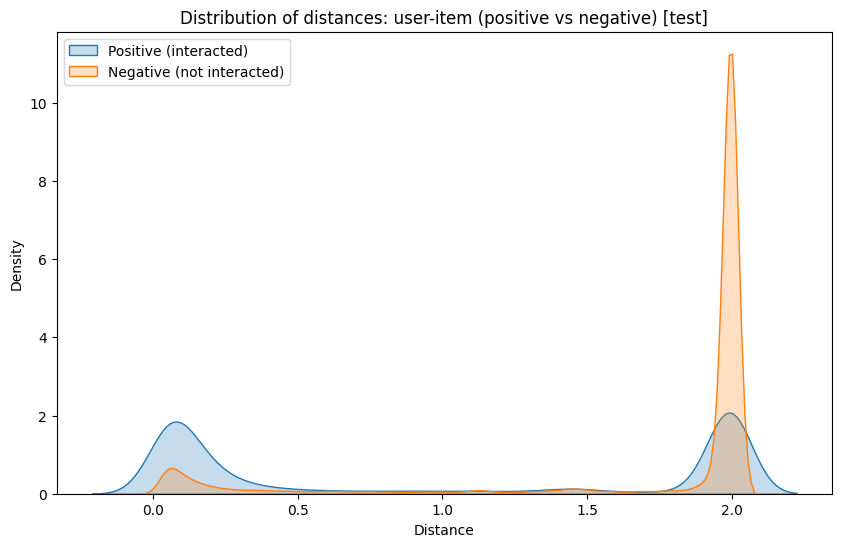

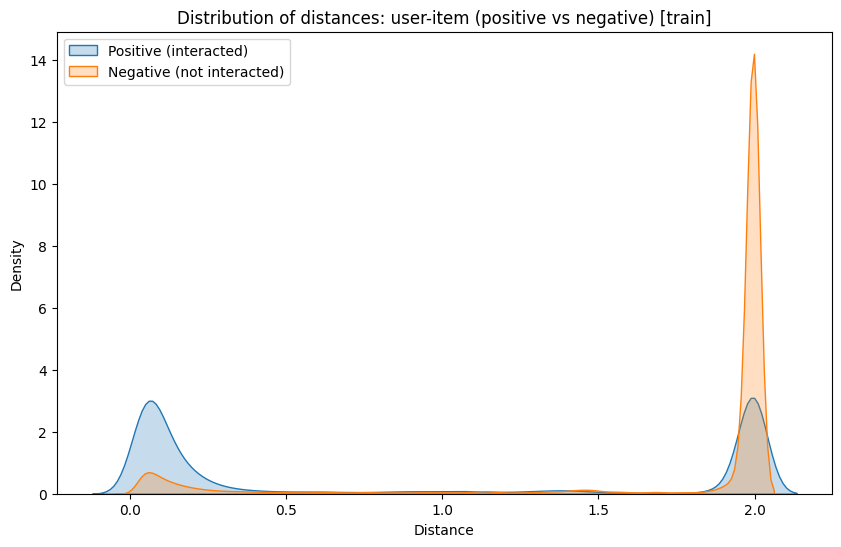

In [ ]:
# --- Inference ---
def get_top_k_recommendations(
    u2v,
    users_meta: np.ndarray,
    interactions_vec: np.ndarray,
    items_vecs: torch.Tensor,
    K: int,
    device: torch.device,
    user_indices: Optional[List] = None,
    batch_size: int = 1024,
    filter_viewed: bool = False,
    user2train_items: Optional[Dict] = None,
    iid_to_item_id: Optional[Dict] = None,
    uid_to_user_id: Optional[Dict] = None,
) -> pd.DataFrame:
    """
    Compute top-K recommendations for users. Returns DataFrame with columns: user_id, item_id, rank.
    """
    dataset = TensorDataset(torch.tensor(users_meta, dtype=torch.float32), torch.arange(users_meta.shape[0]))
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    recos = []
    with torch.no_grad():
        for batch_users_meta, batch_idx in loader:
            batch_users_meta = batch_users_meta.to(device)
            batch_inter_idx = (
                [user_indices[i.item()] for i in batch_idx] if user_indices is not None else batch_idx.tolist()
            )
            batch_users_interaction = torch.tensor(interactions_vec[batch_inter_idx], dtype=torch.float32).to(device)
            batch_users_vec = u2v(batch_users_meta, batch_users_interaction)
            batch_dists = torch.cdist(batch_users_vec, items_vecs)
            batch_dists_np = batch_dists.cpu().numpy()
            if filter_viewed:
                assert user2train_items is not None and iid_to_item_id is not None and uid_to_user_id is not None
                for i, idx in enumerate(batch_idx):
                    uid = user_indices[idx.item()] if user_indices is not None else idx.item()
                    user_id = uid_to_user_id[uid]
                    seen_items = user2train_items.get(user_id, set())
                    n_candidates = K + len(seen_items)
                    reco_iids = np.argsort(batch_dists_np[i])[:n_candidates]
                    reco_item_ids = [iid_to_item_id[iid] for iid in reco_iids]
                    reco_new = [item for item in reco_item_ids if item not in seen_items][:K]
                    for rank, item_id in enumerate(reco_new, 1):
                        recos.append({"user_id": user_id, "item_id": item_id, "rank": rank})
            else:
                batch_topk = np.argsort(batch_dists_np, axis=1)[:, :K]
                for i, idx in enumerate(batch_idx):
                    uid = user_indices[idx.item()] if user_indices is not None else idx.item()
                    user_id = uid_to_user_id[uid]
                    for rank, iid in enumerate(batch_topk[i], 1):
                        item_id = iid_to_item_id[iid]
                        recos.append({"user_id": user_id, "item_id": item_id, "rank": rank})
            del batch_users_meta, batch_users_interaction, batch_users_vec, batch_dists, batch_dists_np
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    return pd.DataFrame(recos)

# --- Plotting ---
def plot_distance_distributions(
    u2v,
    users_meta: np.ndarray,
    interactions_vec: np.ndarray,
    items_vecs: torch.Tensor,
    user2items_ids: Dict,
    all_item_ids: np.ndarray,
    device: torch.device,
    user_indices: List,
    desc: str,
    batch_size: int = 512,
):
    """
    Plot KDE of distances for positive (interacted) and negative (not interacted) user-item pairs.
    """
    pos_distances, neg_distances = [], []
    uids = list(user2items_ids.keys())
    uid_to_meta_idx = {uid: idx for idx, uid in enumerate(uids)}
    meta_indices = [uid_to_meta_idx[uid] for uid in uids]
    users_meta_batch = users_meta[meta_indices]
    users_inter_idx = [user_indices[idx] for idx in meta_indices]
    users_inter_batch = interactions_vec[users_inter_idx]
    dataset = TensorDataset(
        torch.tensor(users_meta_batch, dtype=torch.float32), torch.tensor(users_inter_batch, dtype=torch.float32)
    )
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    user_ptr = 0
    with torch.no_grad():
        for batch_users_meta, batch_users_interaction in loader:
            batch_users_meta = batch_users_meta.to(device)
            batch_users_interaction = batch_users_interaction.to(device)
            batch_users_vec = u2v(batch_users_meta, batch_users_interaction).cpu()
            for i in range(batch_users_vec.shape[0]):
                uid = uids[user_ptr]
                user_vec = batch_users_vec[i].unsqueeze(0)
                pos_iids = list(user2items_ids[uid])
                if pos_iids:
                    pos_item_vecs = items_vecs[pos_iids].detach().cpu()
                    dists = torch.norm(user_vec - pos_item_vecs, dim=1).numpy()
                    pos_distances.extend(dists.tolist())
                neg_iids = list(set(all_item_ids) - set(pos_iids))
                if neg_iids:
                    neg_sample = np.random.choice(neg_iids, size=min(100, len(neg_iids)), replace=False)
                    neg_item_vecs = items_vecs[neg_sample].detach().cpu()
                    dists = torch.norm(user_vec - neg_item_vecs, dim=1).numpy()
                    neg_distances.extend(dists.tolist())
                user_ptr += 1
            del batch_users_meta, batch_users_interaction, batch_users_vec
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    plt.figure(figsize=(10, 6))
    sns.kdeplot(pos_distances, label="Positive (interacted)", fill=True)
    sns.kdeplot(neg_distances, label="Negative (not interacted)", fill=True)
    plt.xlabel("Distance")
    plt.ylabel("Density")
    plt.title(f"Distribution of distances: user-item (positive vs negative) [{desc}]")
    plt.legend()
    plt.show()

# --- Data Preparation ---
def get_users_meta_and_indices(users, users_ohe_df: pd.DataFrame) -> Tuple[List, np.ndarray]:
    """Return sorted user list and their meta features array."""
    users = sorted(users)
    users_meta = users_ohe_df.loc[users].drop(["user_id"], axis=1).values
    return users, users_meta


def calc_metrics_(recos, interactions) -> Dict[str, float]:
    metrics = {
        'ndcg@10': NDCG(k=K_RECOS),
        'map@10': MAP(k=K_RECOS),
        'novelty@10': MeanInvUserFreq(k = K_RECOS),
    }
    return calc_metrics(
        metrics=metrics,
        reco=recos,
        interactions=interactions,
        prev_interactions=train_interactions,
        catalog=train_interactions.item_id.unique()
    )

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
test_interactions_filtered = test_interactions[
    test_interactions.user_id.isin(train_interactions.user_id.unique())
    & test_interactions.item_id.isin(train_interactions.item_id.unique())
]

test_interactions_filtered["uid"] = test_interactions_filtered["user_id"].map(user_id_to_uid)
test_interactions_filtered["iid"] = test_interactions_filtered["item_id"].map(item_id_to_iid)

items_feats = torch.tensor(items_ohe_df.drop(["item_id"], axis=1).values, dtype=torch.float32).to(device)
items_vecs = i2v(items_feats)


# Inference: test set (all items)
test_users, test_users_meta = get_users_meta_and_indices(test_interactions_filtered.uid.unique(), users_ohe_df)
df_dssm_test = get_top_k_recommendations(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=test_users,
    filter_viewed=False,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on test set (all items):')
print(calc_metrics_(df_dssm_test, test_interactions_filtered))

# Inference: test set (only new items)
user2train_items = train_interactions.groupby("user_id")["item_id"].apply(set).to_dict()
df_dssm_test_new = get_top_k_recommendations(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=test_users,
    filter_viewed=True,
    user2train_items=user2train_items,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on test set (only new items):')
print(calc_metrics_(df_dssm_test_new, test_interactions_filtered))

# Inference: all train users
all_users, all_users_meta = get_users_meta_and_indices(train_interactions.uid.unique(), users_ohe_df)
df_dssm = get_top_k_recommendations(
    u2v,
    all_users_meta,
    train_interactions_vec,
    items_vecs,
    K_RECOS,
    device,
    user_indices=all_users,
    filter_viewed=False,
    iid_to_item_id=iid_to_item_id,
    uid_to_user_id=uid_to_user_id,
)
print('Metrics on train set:')
print(calc_metrics_(df_dssm, train_interactions))


# Plotting: test
test_user2items_ids = test_interactions_filtered.groupby("uid")["iid"].apply(set).to_dict()
all_item_ids = train_interactions.iid.unique()
plot_distance_distributions(
    u2v,
    test_users_meta,
    train_interactions_vec,
    items_vecs,
    test_user2items_ids,
    all_item_ids,
    device,
    user_indices=test_users,
    desc="test",
    batch_size=128,
)
# Plotting: train
train_user2items_ids = train_interactions.groupby("uid")["iid"].apply(set).to_dict()
plot_distance_distributions(
    u2v,
    all_users_meta,
    train_interactions_vec,
    items_vecs,
    train_user2items_ids,
    all_item_ids,
    device,
    user_indices=all_users,
    desc="train",
    batch_size=128,
)

# –ò—Ç–æ–≥–æ

- –†–µ–∞–ª–∏–∑–æ–≤–∞–ª –æ–±—É—á–µ–Ω–∏–µ –∏ –∏–Ω—Ñ–µ—Ä–µ–Ω—Å –Ω–∞ GPU
- –†–∞–∑–±–∏–ª –¥–∞–Ω–Ω—ã–µ –Ω–∞ —Ç–µ—Å—Ç–æ–≤—É—é –∏ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω—É—é –º–µ—Ç—Ä–∏–∫—É
- –†–µ–∞–ª–∏–∑–æ–≤–∞–ª —Ä–∞—Å—á–µ—Ç –º–µ—Ç—Ä–∏–∫
- –û–±—É—á–∏–ª lightfm –¥–ª—è —Å—Ä–∞–≤–Ω–µ–Ω–∏—è. –ó–∞–º–µ—Ç–∏–ª, —á—Ç–æ –±–µ–∑ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏ –¥–∞—Ç–∞—Å–µ—Ç–∞ –º–µ—Ç—Ä–∏–∫–∞ –Ω–∞ —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–µ –Ω–∞–º–Ω–æ–≥–æ –ª—É—á—à–µ
- –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–∞–º–∏ `UserModel` –∏ `ItemModel`:  
    - –î–æ–±–∞–≤–ª–µ–Ω—ã —Å–ª–æ–∏ `BatchNorm1d` –∏ `dropout`.
    - –î–æ–±–∞–≤–ª–µ–Ω `TransformerEncoderLayer`. –°–Ω–∞—á–∞–ª–∞ –¥–æ–±–∞–≤–∏–ª —ç—Ç–æ—Ç —Å–ª–æ–π –¥–ª—è –º–µ—Ç–∞ –¥–∞–Ω–Ω—ã—Ö —é–∑–µ—Ä–æ–≤ –∏ –∞–π—Ç–µ–º–æ–≤, –ø–æ—Ç–æ–º –ø–æ–Ω—è–ª, —á—Ç–æ –µ–≥–æ –Ω—É–∂–Ω–æ –¥–æ–±–∞–≤–ª—è—Ç—å –¥–ª—è –≤–µ–∫—Ç–æ—Ä–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π. –ù–æ –ø–æ—Å–ª–µ –±–æ–ª–µ–µ –ø–æ–¥—Ä–æ–±–Ω–æ–≥–æ –∏–∑—É—á–µ–Ω–∏—è –ø–æ–Ω—è–ª, —á—Ç–æ –≤–µ–∫—Ç–æ—Ä–∞ –≤–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–π –¥–æ–ª–∂–Ω—ã —É—á–∏—Ç—ã–≤–∞—Ç—å –≤—Ä–µ–º–µ–Ω–Ω—É—é —Å–æ—Å—Ç–∞–≤–ª—è—é—â—É, —á—Ç–æ–±—ã —Ä–∞–±–æ—Ç–∞–ª –º–µ—Ö–∞–Ω–∏–∑–º –≤–Ω–∏–º–∞–Ω–∏—è. –ó–∞–¥–∞—á–∞ –Ω–µ—Ç—Ä–∏–≤–∏–∞–ª—å–Ω–∞—è, –ø—Ä–∏–Ω—è–ª —Ä–µ—à–µ–Ω–∏–µ –ø–æ–∫–∞ –æ—Ç–∫–∞–∑–∞—Ç—å—Å—è –æ—Ç –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –¥–∞–Ω–Ω–æ–≥–æ —Å–ª–æ—è
    - –î–æ–±–∞–≤–ª–µ–Ω —ç—Ç–∞–ø LN, —ç—Ç–æ –ø–æ–∑–≤–æ–ª–∏–ª–æ –¥–æ–±–∏—Ç—å—Å—è –Ω–∞–∏–ª—É—á—à–∏—Ö —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
- –†–µ–∞–ª–∏–∑–æ–≤–∞–Ω –∏–Ω—Ñ–µ—Ä–µ–Ω—Å —Å —Ä–∞—Å—Å—á–µ—Ç–æ–º `MAP`, `NDCG`, `novelty` –∏ –≤—ã–≤–æ–¥–æ–º –≥–∏—Å—Ç–æ–≥—Ä–∞–º–º —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π –º–µ–∂–¥—É –ø–æ–∑–∏—Ç–∏–≤–æ–º –∏ –Ω–µ–≥–∞—Ç–∏–≤–æ–º. –ò–Ω—Ñ–µ—Ä–µ–Ω—Å –¥–ª—è —Ç–µ—Å—Ç–æ–≤–æ–π –≤—ã–±–æ—Ä–∫–∏ —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω –≤ 2—Ö –≤–∞—Ä–∏–∞–Ω—Ç–∞—Ö: —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ–º –≤—Å–µ item –∏–ª–∏ —Ä–µ–∫–æ–º–µ–Ω–¥—É–µ–º —Ç–æ–ª—å–∫–æ –Ω–æ–≤—ã–µ. –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—é —Ç–æ–ª—å–∫–æ –Ω–µ–ø—Ä–æ—Å–º–æ—Ç—Ä–µ–Ω–Ω—ã—Ö item –ø–æ–∑–≤–æ–ª–∏–ª–∞ —É–ª—É—á—à–∏—Ç—å –º–µ—Ç—Ä–∏–∫—É `MAP` –∏ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ —É–ª—É—á—à–∏—Ç—å `novelty`
- –†–µ–∞–ª–∏–∑–æ–≤–∞–Ω BPR_loss. –° —ç—Ç–∏–º –ª–æ—Å—Å–æ–º –Ω–µ —É–¥–∞–ª–æ—Å—å –¥–æ–±–∏—Ç—å—Å—è —Å—Ö–æ–¥–∏–º–æ—Å—Ç–∏. –ü—Ä–æ–≤–æ–¥–∏–ª–∏—Å—å —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä–æ–π, —Å—ç–º–ø–ª–∏—Ä–æ–≤–∞–Ω–∏–µ–º –Ω–µ–≥–∞—Ç–∏–≤–Ω—ã—Ö –ø—Ä–∏–º–µ—Ä–æ–≤, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —ç–ø–æ—Ö, learning_rate, —Ä–∞–∑–º–µ—Ä–æ–º –±–∞—Ç—á–∞. –ù–∏—á–µ–≥–æ –∏–∑ —ç—Ç–æ–≥–æ –Ω–µ –ø–æ–º–æ–≥–ª–æ, –ø—Ä–∏–Ω—è—Ç–æ —Ä–µ—à–µ–Ω–∏–µ –æ—Å—Ç–∞–Ω–æ–≤–∏—Ç—å—Å—è –Ω–∞ triplet_loss
- UPD –ø–æ BPR_loss. –ü–æ—Å–ª–µ –∞–Ω–∞–ª–∏–∑–∞ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π –¥–ª—è –ø–æ–∑–∏—Ç–∏–≤–æ–≤ –∏ –Ω–µ–≥–∞—Ç–∏–≤–æ–≤ –∑–∞–º–µ—Ç–∏–ª, —á—Ç–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏—ã –ø—Ä–∏–º–µ—Ä–Ω–æ –æ—Ç 50 –¥–æ 255, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –¥–ª—è triplet_loss –æ–Ω–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω—ã –æ—Ç 0.5 –¥–æ 4. –ù–∞–∫–∞—Ç–∏–ª–æ –æ—Å–æ–∑–Ω–∞–Ω–∏–µ, —á—Ç–æ –Ω—É–∂–Ω–æ –ø–æ–ø—Ä–æ–±–æ–≤–∞—Ç—å –¥–æ–±–∞–≤–∏—Ç—å –≤ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É L2 –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—é –¥–ª—è —ç–º–±–µ–¥–¥–∏–Ω–≥–æ–≤ –ø—Ä–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–∏ bpr_loss.
–í –∏—Ç–æ–≥–µ —ç—Ç–æ –Ω–µ –ø–æ–º–æ–≥–ª–æ, –Ω–æ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π –ø–æ–º–µ–Ω—è–ª–æ—Å—å. –ü–æ—è–≤–∏–ª—Å—è –±—É–≥–æ—Ä –æ–∫–æ–ª–æ 0 –∏ –±—É–≥–æ—Ä –æ–∫–æ–ª–æ 2—Ö.

–î—Ä–æ–ø–∞—É—Ç—ã, —Ç—Ä–∏–ø–ª–µ—Ç—Ç –ª–æ—Å—Å

Metrics on test set (all items):  
{'ndcg@10': 0.020150051921643704, 'map@10': 0.03442064385565833, 'novelty@10': 6.6893864751852234}  
Metrics on test set (only new items):  
{'ndcg@10': 0.022607524303127062, 'map@10': 0.040237918803309895, 'novelty@10': 7.4382998570788175}  
Metrics on train set:  
{'ndcg@10': 0.1528670560518531, 'map@10': 0.08338817995936873, 'novelty@10': 6.150502687035253}  

![image-1.png](images/image_1.png)
![image-2.png](images/image_2.png)

–¢—Ä–∏–ø–ª–µ—Ç –ª–æ—Å—Å, –¥—Ä–æ–ø–∞—é—Ç, LN, 5 —ç–ø–æ—Ö:  
–ü–æ—Å–ª–µ –¥–æ–±–∞–≤–ª–µ–Ω–∏—è —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π –Ω–∞ —Ç—Ä–µ–Ω–∏—Ä–æ–≤–æ—á–Ω–æ–º –∏ —Ç–µ—Å—Ç–æ–≤–æ–º –¥–∞—Ç–∞—Å–µ—Ç–∞—Ö —Å–º–µ—Å—Ç–∏–ª–æ—Å—å –≤–ª–µ–≤–æ.  

Metrics on test set (all items):  
{'ndcg@10': 0.02362516138072357, 'map@10': 0.04165041467247998, 'novelty@10': 6.704579471536163}  
Metrics on test set (only new items):  
{'ndcg@10': 0.026416019038800274, 'map@10': 0.049272534531008376, 'novelty@10': 7.410556220576975}  
Metrics on train set:  
{'ndcg@10': 0.1590928053856303, 'map@10': 0.09365070823244875, 'novelty@10': 6.296392580539426}  

![image-3.png](images/image_3.png)
![image-4.png](images/image_4.png)


 
BPR_loss  
Metrics on test set (all items):  
{'ndcg@10': 0.00022799403808741964, 'map@10': 0.0002336042134449884, 'novelty@10': 11.537375548766876}  
Metrics on test set (only new items):  
{'ndcg@10': 0.00022876025679039637, 'map@10': 0.00023424274043325845, 'novelty@10': 11.541674360437256}  
Metrics on train set:  
{'ndcg@10': 0.0017234810371572673, 'map@10': 0.00032141210525153517, 'novelty@10': 11.554501635683124}  

![image-5.png](images/image_5.png)
![image-6.png](images/image_6.png)

BPR_loss L2_norm  
Metrics on test set (all items):  
{'ndcg@10': 0.004268759723329381, 'map@10': 0.007981950890367883, 'novelty@10': 10.359371160120494}  
Metrics on test set (only new items):  
{'ndcg@10': 0.004424605129663591, 'map@10': 0.00840846146571718, 'novelty@10': 10.507040145281902}  
Metrics on train set:  
{'ndcg@10': 0.026595616391652716, 'map@10': 0.014998711478326257, 'novelty@10': 10.474641643549294}  

![image-7.png](images/image_7.png)
![image-8.png](images/image_8.png)

# üß† DSSM Homework: Improve the Model

Welcome! This assignment builds upon the DSSM model you studied during the seminar.

Your task is to **improve the DSSM model** by modifying the architecture, loss function, evaluation, or training pipeline. This is an open-ended assignment meant to encourage exploration.

In this seminar, you've explored a basic implementation of the Deep Structured Semantic Model (DSSM).

Your task is to **improve this model** in one or more of the following directions:

### ‚úÖ Model Improvements
- Replace MLP towers with Transformer or RNN encoders or etc. (5 –±–∞–ª–ª–æ–≤)
- Use different triplet loss. (3 –±–∞–ª–ª–∞) 5 21:10
- Add dropout, batch normalization, or layer norm. (3 –±–∞–ª–ª–∞)
- Integrate embeddings instead of one-hot vectors. (5 –±–∞–ª–ª–æ–≤)
- Visualize similarity distribution for positive vs. negative pairs. (5 –±–∞–ª–ª–æ–≤)

### ‚úÖ Evaluation & Analysis
- Visualize embeddings using t-SNE or UMAP. (3 –±–∞–ª–ª–æ–≤)
- Develop and improve beyond accuracy metrics. (5 –±–∞–ª–ª–æ–≤) 1:14

### üìÑ Deliverables
- Explain what you changed and why in the final markdown cell. (3 –±–∞–ª–ª–∞)
- Keep code modular, clean, and well-documented. (3 –±–∞–ª–ª–∞)

### üìù Production
- create service based on DSSM vectors with ANN. (8 –±–∞–ª–ª–æ–≤)

### üìù Leaderboard
- Improve score from UserKNN via DSSM (8 –±–∞–ª–ª–æ–≤)


–ú–∞–∫—Å–∏–º—É–º –±–∞–ª–ª–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ –º–æ–∂–Ω–æ –ø–æ–ª—É—á–∏—Ç—å - 25.